In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import cv2
from skimage.feature import hog
import pickle
from tqdm import tqdm

In [2]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
dpi = matplotlib.rcParams['figure.dpi']

### Initialize classify model

In [4]:
clf = LinearSVC()

In [5]:
print(clf)

LinearSVC()


### Load positive samples

In [6]:
file = open('HOG_16x32', 'rb')
X_pos = pickle.load(file)
file.close()

In [7]:
X_pos.shape

(25954, 756)

### Load negative samples

In [8]:
file = open('negative_set.p', 'rb')
X_neg = pickle.load(file)
file.close()

In [9]:
X_neg.shape

(68314, 756)

### Create label for each set

In [10]:
y_pos = np.ones(X_pos.shape[0])
y_neg = np.zeros(X_neg.shape[0])

In [11]:
X = np.vstack((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

### Split into training set and validation set

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)

In [15]:
clf.fit(X_train,y_train)

LinearSVC()

In [16]:
print('Score trên tập train: ', clf.score(X_train,y_train))

Score trên tập train:  0.9819661448467122


In [19]:
print('Score trên tập validation: ', clf.score(X_val, y_val))

Score trên tập validation:  0.9791732965595276


In [20]:
y_train_pred = clf.predict(X_train)
print(confusion_matrix(y_train, y_train_pred))

[[47418   393]
 [  797 17379]]


In [21]:
y_val_pred = clf.predict(X_val)
print(confusion_matrix(y_val, y_val_pred))

[[20306   197]
 [  392  7386]]


### Test with some image in test folder

In [22]:
def sliding_window(im, step, winSize=(16,32)):
    """
    Perform sliding window on image
    @INPUT:
        - im: Image
        - step: Step in pixels between window
        - winSize: window size, tupple (width, height)
    @OUTPUT:
        - window: window of size winSize
    """
    # slide a window across the image
    for y in range(0, im.shape[0], step):
        for x in range(0, im.shape[1], step):
            # yield the current window
            yield (x, y, im[y:y + winSize[1], x:x + winSize[0]])

In [23]:
def pre_process(path, name, factor=1.3):
    """
    Preprocess image: RGB image --> Gray image --> Blur image (reduce noise) --> High Pass Filter (sharpen)         --> Constrast Limited Adaptive Histogram Equalization --> Exposure
    @INPUT:
        - path: image path
        - name: image name
        - factor: exposure factor
    @OUTPUT:
        - imgAHE: preprocessed image
    """
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]], np.float32)
    
    img = cv2.imread(os.path.join(path, name))

    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to gray image

    imgBlur = cv2.GaussianBlur(imgGray, (3,3), 0)   # reduce noise

    imgH = cv2.filter2D(imgBlur, -1, kernel)        # sharpen

    AHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))# Contrast Limited Adaptive Histogram Equalization 
    imgAHE = AHE.apply(imgH)
    imgAHE = np.array(imgAHE)

    img_processed = imgAHE*factor   # exposure

    return img_processed

In [24]:
test_path = '../data/test/'

In [25]:
names = os.listdir(test_path)

(55, 87)


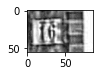

In [42]:
im = pre_process(test_path, '10.png')
figsize = im.shape[1]/dpi, im.shape[0]/dpi
print(im.shape)
plt.figure(figsize=figsize)
plt.imshow(im, cmap='gray')
plt.show()

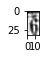

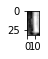

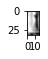

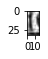

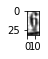

In [43]:
for (x, y, window) in sliding_window(im, step=8, winSize=(16, 32)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != 32 or window.shape[1] != 16:
        continue
    # Calculate HOG feature of window
    fd = hog(window, orientations=9, pixels_per_cell=(4,4), cells_per_block=(2,2))
    # Predict if window contains number or background
    fd = fd.reshape(1,-1)
    pred = clf.predict(fd)
    if pred:
        figsize = window.shape[1]/dpi, window.shape[0]/dpi
        plt.figure(figsize=figsize)
        plt.imshow(window, cmap='gray')
        plt.show()